This notebook includes functions for plotting the figures reported in the paper.

In [3]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [4]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [5]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [6]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [7]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [6]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/experiments/10032023_v3.2_exps


In [8]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/results_bigred"

# Directory to save figures
PLOT_DIR = "figures_results_bigred"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [9]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [11]:
folders = ["baseline_5runs"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.3821982373356916]
values [0.3847215532089949]
values [0.39299586631365724]
values [0.40741383426120265]
values [0.38959178569815656]
Overall quality when there is no bots: 0.39


# Shuffle 
Effects of network structure on Quality

In [12]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.383542,0.378106,0.381208,0.369091,0.408733,all_shuffle__None2.json,all
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.372875,0.360693,0.365105,0.363559,0.361026,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.427008,0.405848,0.422218,0.396089,0.382759,community_shuffle__None2.json,community


In [16]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [17]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
18,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.375325,0.366729,0.377219,0.382236,0.381245,None


In [18]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.383542,0.378106,0.381208,0.369091,0.408733,all_shuffle__None2.json,all
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.372875,0.360693,0.365105,0.363559,0.361026,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.427008,0.405848,0.422218,0.396089,0.382759,community_shuffle__None2.json,community


In [19]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [20]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.375325,...,0.382236,0.381245,None,NaN,0.958967,0.937005,0.963808,0.976625,0.974094,0
1,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.383542,...,0.369091,0.408733,all,all_shuffle__None2.json,0.979962,0.966074,0.973999,0.943040,1.044326,1
2,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.372875,...,0.363559,0.361026,hub,hub_shuffle__None2.json,0.952707,0.921584,0.932855,0.928906,0.922433,2
3,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.427008,...,0.396089,0.382759,community,community_shuffle__None2.json,1.091020,1.036956,1.078781,1.012021,0.977962,3


In [21]:
results

,id,run_no,gamma,rho,phi,quality_3,theta,quality_4,graph_gml,quality_0,targeting_criterion,beta,shuffle,mu,quality_1,epsilon,quality_2,file_name,relative_quality_
0,0,0,0.01,0.8,0.0,0.382236,1,0.381245,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.375325,none,0.05,None,0.5,0.366729,0.0001,0.377219,NaN,0.958967
1,1,0,0.01,0.8,0.0,0.369091,1,0.408733,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.383542,none,0.05,all,0.5,0.378106,0.0001,0.381208,all_shuffle__None2.json,0.979962
2,2,0,0.01,0.8,0.0,0.363559,1,0.361026,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.372875,none,0.05,hub,0.5,0.360693,0.0001,0.365105,hub_shuffle__None2.json,0.952707
3,3,0,0.01,0.8,0.0,0.396089,1,0.382759,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.427008,none,0.05,community,0.5,0.405848,0.0001,0.422218,community_shuffle__None2.json,1.091020
4,0,1,0.01,0.8,0.0,0.382236,1,0.381245,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.375325,none,0.05,None,0.5,0.366729,0.0001,0.377219,NaN,0.937005
5,1,1,0.01,0.8,0.0,0.369091,1,0.408733,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.383542,none,0.05,all,0.5,0.378106,0.0001,0.381208,all_shuffle__None2.json,0.966074
6,2,1,0.01,0.8,0.0,0.363559,1,0.361026,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.372875,none,0.05,hub,0.5,0.360693,0.0001,0.365105,hub_shuffle__None2.json,0.921584
7,3,1,0.01,0.8,0.0,0.396089,1,0.382759,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.427008,none,0.05,community,0.5,0.405848,0.0001,0.422218,community_shuffle__None2.json,1.036956
8,0,2,0.01,0.8,0.0,0.382236,1,0.381245,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.375325,none,0.05,None,0.5,0.366729,0.0001,0.377219,NaN,0.963808
9,1,2,0.01,0.8,0.0,0.369091,1,0.408733,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.383542,none,0.05,all,0.5,0.378106,0.0001,0.381208,all_shuffle__None2.json,0.973999


Plot data for default values $\gamma=0.01$

In [22]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,gamma,rho,phi,quality_3,theta,quality_4,graph_gml,quality_0,targeting_criterion,beta,shuffle,mu,quality_1,epsilon,quality_2,file_name,relative_quality_
0,0,0,0.01,0.8,0.0,0.382236,1,0.381245,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.375325,none,0.05,None,0.5,0.366729,0.0001,0.377219,NaN,0.958967
1,1,0,0.01,0.8,0.0,0.369091,1,0.408733,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.383542,none,0.05,all,0.5,0.378106,0.0001,0.381208,all_shuffle__None2.json,0.979962
2,2,0,0.01,0.8,0.0,0.363559,1,0.361026,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.372875,none,0.05,hub,0.5,0.360693,0.0001,0.365105,hub_shuffle__None2.json,0.952707
3,3,0,0.01,0.8,0.0,0.396089,1,0.382759,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.427008,none,0.05,community,0.5,0.405848,0.0001,0.422218,community_shuffle__None2.json,1.091020
4,0,1,0.01,0.8,0.0,0.382236,1,0.381245,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.375325,none,0.05,None,0.5,0.366729,0.0001,0.377219,NaN,0.937005


In [23]:
# !pip install statannotations

In [24]:
# plot_data

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:1.787e-02 t=3.500e+00
hubs vs. communities: Welch's t-test independent samples, P_val:5.345e-03 t=-4.970e+00
random vs. hubs: Welch's t-test independent samples, P_val:3.941e-02 t=2.791e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:3.357e-01 t=1.057e+00


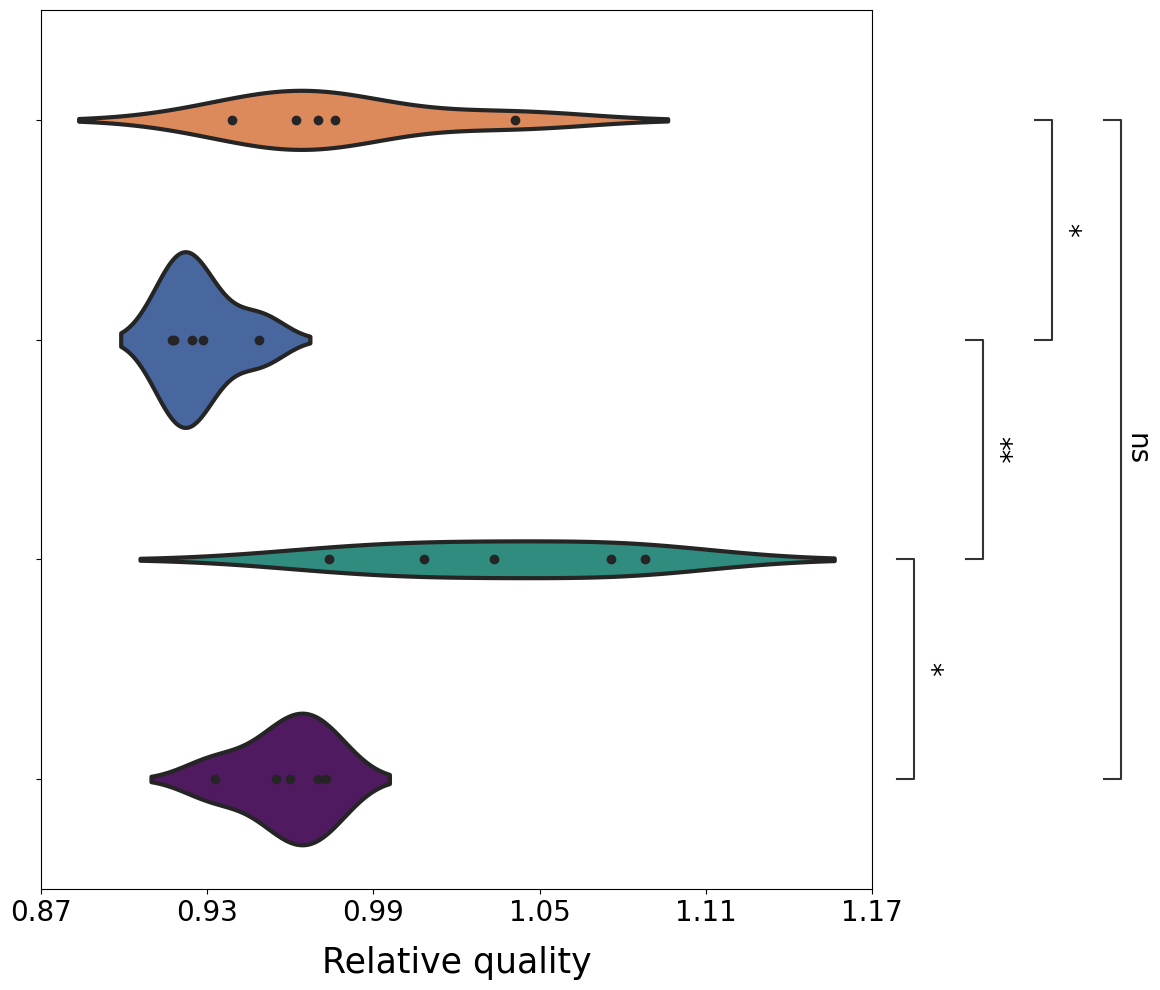

In [25]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
# patch_violinplot(ax, palette=BLUEPALETTE, n=4)
# point_violinplot(ax, palette=BLUEPALETTE, n=4)
# sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [26]:
folders = ["vary_alpha_nobots_5runs"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,gamma,rho,phi,relative_quality_4,theta,relative_quality_0,graph_gml,relative_quality_2,alpha,targeting_criterion,beta,mu,relative_quality_3,epsilon,relative_quality_1,quality_
13,5,1,0.01,0.8,0,0.84133,1,0.801254,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.832659,1,none,0.05,0.5,0.798311,0.0001,0.737101,0.288490
5,5,0,0.01,0.8,0,0.84133,1,0.801254,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.832659,1,none,0.05,0.5,0.798311,0.0001,0.737101,0.313598
21,5,2,0.01,0.8,0,0.84133,1,0.801254,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.832659,1,none,0.05,0.5,0.798311,0.0001,0.737101,0.325889
37,5,4,0.01,0.8,0,0.84133,1,0.801254,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.832659,1,none,0.05,0.5,0.798311,0.0001,0.737101,0.329283
29,5,3,0.01,0.8,0,0.84133,1,0.801254,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.832659,1,none,0.05,0.5,0.798311,0.0001,0.737101,0.312446


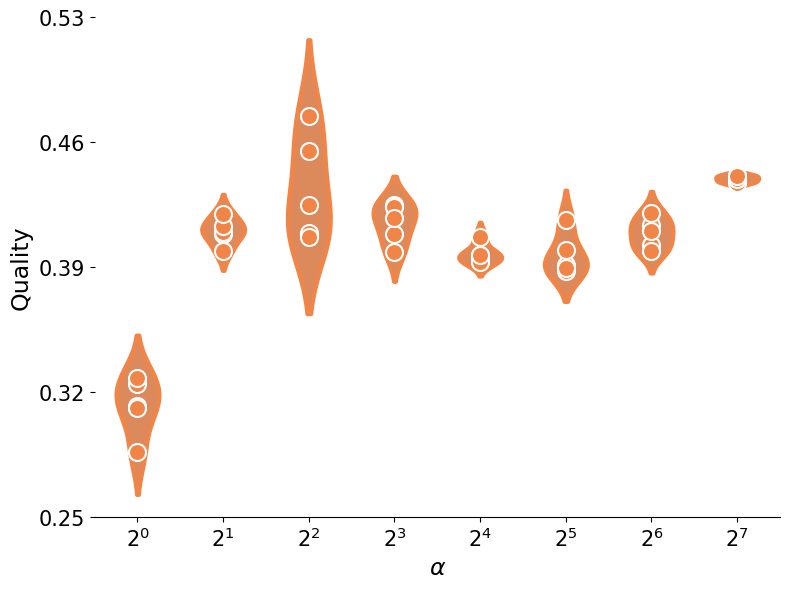

In [27]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [28]:
# Read data
data = read_data(RES_DIR, ["vary_mu_nobots_5runs"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,gamma,rho,phi,theta,graph_gml,targeting_criterion,alpha,beta,mu,epsilon,quality_
3,3,0,0.01,0.8,0,1,/N/slate/baotruon/simsom_data/data/igraph/netw...,none,15,0.05,0.1,0.0001,0.554211
8,3,1,0.01,0.8,0,1,/N/slate/baotruon/simsom_data/data/igraph/netw...,none,15,0.05,0.1,0.0001,0.518881
18,3,3,0.01,0.8,0,1,/N/slate/baotruon/simsom_data/data/igraph/netw...,none,15,0.05,0.1,0.0001,0.567958
23,3,4,0.01,0.8,0,1,/N/slate/baotruon/simsom_data/data/igraph/netw...,none,15,0.05,0.1,0.0001,0.543914
13,3,2,0.01,0.8,0,1,/N/slate/baotruon/simsom_data/data/igraph/netw...,none,15,0.05,0.1,0.0001,0.580041


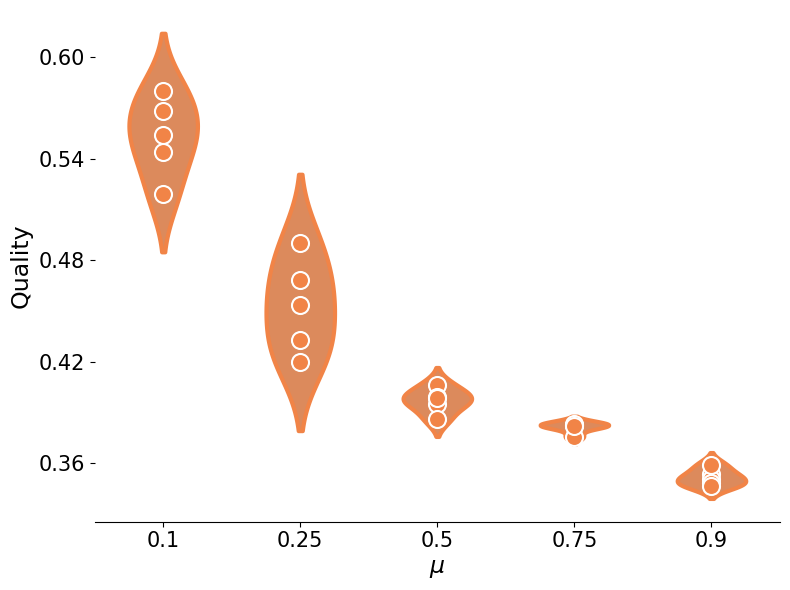

In [29]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [30]:
data = read_data(
    RES_DIR, folders=["vary_thetaphi_4runs","vary_thetaphi_5runs", "vary_thetaphi"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

Error reading results from folder vary_thetaphi
'targeting_criterion'


In [31]:
thetaphi

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,alpha,quality_4,quality_5,quality_6,quality_7,quality_8
0,8,0.05,0.01,0.5,0.0001,0.2,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.288054,0.289060,0.316234,0.318411,15,NaN,NaN,NaN,NaN,NaN
1,16,0.05,0.01,0.5,0.0001,0.3,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.361762,0.364468,0.351024,0.382047,15,NaN,NaN,NaN,NaN,NaN
2,16,0.05,0.01,0.5,0.0001,0.1,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.312113,0.254510,0.279029,0.254459,15,NaN,NaN,NaN,NaN,NaN
3,32,0.05,0.01,0.5,0.0001,0.6,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.350611,0.321177,0.360767,0.331362,15,NaN,NaN,NaN,NaN,NaN
4,8,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.356832,0.363361,0.365681,0.359832,15,NaN,NaN,NaN,NaN,NaN
5,4,0.05,0.01,0.5,0.0001,0.4,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.370510,0.350645,0.374681,0.359035,15,0.364429,0.364873,0.359110,0.368996,0.366044
6,8,0.05,0.01,0.5,0.0001,0.6,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.281907,0.270677,0.284206,0.285301,15,NaN,NaN,NaN,NaN,NaN
7,32,0.05,0.01,0.5,0.0001,0.4,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.356273,0.349154,0.359389,0.377308,15,0.379954,0.333959,0.356595,0.367045,0.327020
8,2,0.05,0.01,0.5,0.0001,0.8,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.391232,0.371451,0.366509,0.374504,15,0.367036,0.354377,0.366536,0.381244,0.369844
9,2,0.05,0.01,0.5,0.0001,0.7,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.336018,0.317583,0.315858,0.335258,15,NaN,NaN,NaN,NaN,NaN


### Phigamma

In [32]:
data = read_data(
    RES_DIR, folders=["vary_phigamma","vary_phigamma_5runs","vary_phigamma_5runs_"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

Error reading results from folder vary_phigamma
'targeting_criterion'


### Thetagamma

In [33]:
data = read_data(RES_DIR, folders=["vary_thetagamma","vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

Error reading results from folder vary_thetagamma
'targeting_criterion'


## Single param plots
Subset data (only plot default values for each panel)

In [34]:
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,quality_1_y,quality_2_y,quality_3_y,quality_4_y,alpha_y,quality_5_y,quality_6_y,quality_7_y,quality_8_y,quality_9
0,1,0.05,0.01,0.5,0.0001,0.4,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.330006,...,0.362070,0.364829,0.375867,0.360502,15,NaN,NaN,NaN,NaN,NaN
1,1,0.05,0.01,0.5,0.0001,0.8,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.369687,...,0.358498,0.358143,0.363996,0.370899,15,NaN,NaN,NaN,NaN,NaN
2,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.366345,0.391408,0.373592,0.371862,15,NaN,NaN,NaN,NaN,NaN
3,1,0.05,0.01,0.5,0.0001,0.5,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.345122,0.380589,0.349278,0.376257,15,0.332225,0.346342,0.33471,0.338972,0.339075


In [35]:
# VARYING GAMMA
vary_gamma = pd.merge(
    phigamma[phigamma.phi == 0],
    thetagamma[thetagamma.theta == 1],
    on=["theta", "beta", "gamma", "phi"],
)
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
# x = [0.1 * i for i in vary_phi["phi"]]
x = vary_phi["phi"].values
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = pd.merge(
    thetaphi[thetaphi.phi == 0],
    thetagamma[thetagamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9647558373177137, 0.95778991519844, 0.9727082139452988, 0.9702912985261812, 1.0089576622254877, 1.0093545008298423, 0.9561584998557607, 0.9626204630893661, 0.9625380028862454, 0.9785341484059937]
values [1.0528920072983403, 1.0058998505060945, 0.9628241948126262, 0.975641789260063, 0.9635478952246689, 1.0449043237782132, 0.9994295436069772, 0.9929437257529452, 1.0796832865448045, 0.988291477374999]
values [0.8431765122585054, 0.8380810499471089, 0.8651014987490626, 0.8419059263469038, 0.9495957356733239, 0.9251022235963374, 0.9321492024242505, 0.960353628268498, 0.9210959677405224]
values [0.9445620372699477, 0.9399161417402846, 0.9476379833028021, 0.8696808141488126, 0.8403757409760355, 0.8292674564344913, 0.8237870453435875, 0.8461787562354183, 0.841874063662475, 0.9856004563416323, 0.9159735365532159, 0.9150685081022037, 0.9300231890523266, 0.9476603286288631]
values [0.9589670210393862, 0.9370051068372816, 0.9638077739754042, 0.9766249464241725, 0.9740943590493631, 0.8988

In [36]:
vary_gamma

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,relative_quality_8,relative_quality_9,relative_quality_10,relative_quality_11,relative_quality_12,relative_quality_13,relative_quality_14,mean_relative_quality,std_relative_quality,ci_relative_quality
0,1,0.05,0.0010,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.377590,...,NaN,NaN,1.009355,0.956158,0.962620,0.962538,0.978534,0.974371,0.019533,0.013973
1,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.412085,...,NaN,NaN,1.044904,0.999430,0.992944,1.079683,0.988291,1.006606,0.039796,0.028468


### Plot

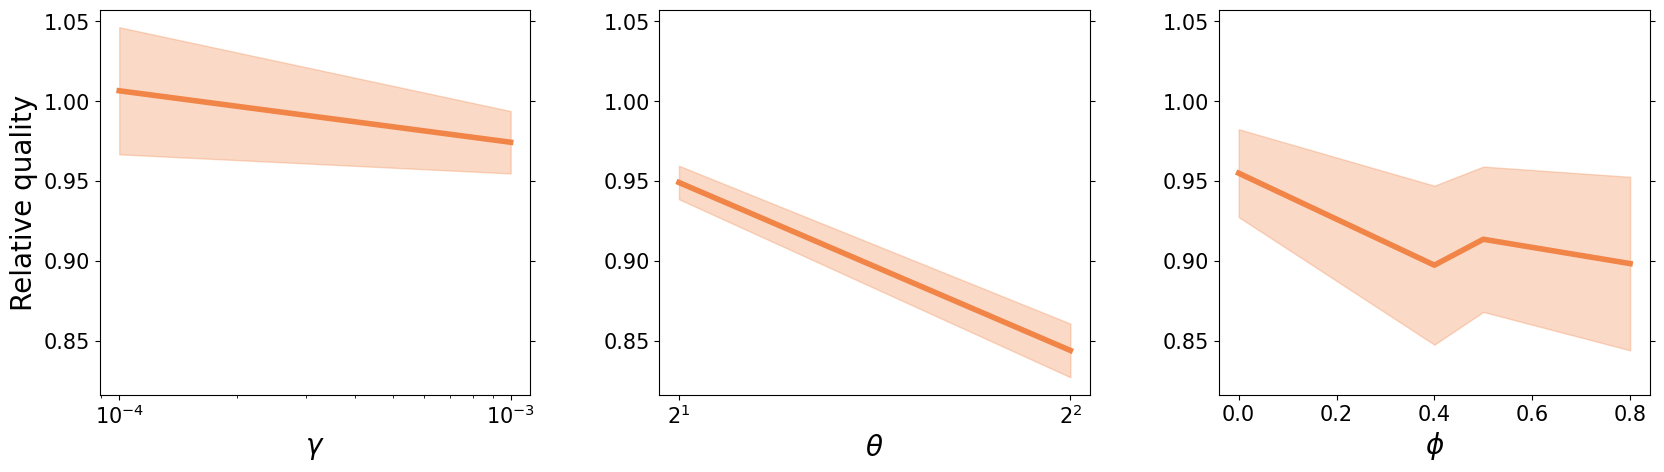

In [37]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [38]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

values [0.7359864346841243, 0.738557318330475, 0.807987438372008, 0.8135496333933946]
values [0.9243139627809606, 0.9312281794861823, 0.896876949530998, 0.9761427962544762]
values [0.7974588377110855, 0.6502828930770678, 0.7129279538086558, 0.6501519589681397]
values [0.8958217893793511, 0.8206177540415529, 0.921771287720093, 0.8466414910476825]
values [0.9117176923803091, 0.9284002892557933, 0.9343267223681123, 0.9193819596239264]
values [0.9466645822662563, 0.8959086996013884, 0.957322945101119, 0.9173467755177093, 0.9311286962258637, 0.9322623682658306, 0.917538926737736, 0.942796211017856, 0.9352560571936451]
values [0.7202819619849768, 0.6915899117519854, 0.7261548155071006, 0.7289548240482876]
values [0.9102890015153935, 0.8921012962385758, 0.9182510017774136, 0.9640349636242389, 0.9707952788249508, 0.8532769697757406, 0.9111111206657797, 0.9378124095225469, 0.8355482499962065]
values [0.99961160406507, 0.949070635803765, 0.9364434457537046, 0.9568694431489974, 0.9377886328746295

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.962100,0.855414,NaN,NaN,0.847066,0.952300,NaN,NaN,0.875920,NaN,NaN
1,2,0.949049,NaN,NaN,NaN,0.795914,NaN,0.841572,0.833399,0.948978,0.918349,0.809052
2,4,0.840993,0.800711,NaN,0.798985,0.930692,0.933186,0.770425,0.734462,NaN,0.760075,NaN
3,8,0.923457,NaN,0.77402,NaN,0.752401,0.904139,0.716745,NaN,NaN,NaN,NaN
4,16,NaN,0.702705,NaN,0.932140,NaN,NaN,NaN,0.679471,0.928657,NaN,NaN


In [39]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

(7, 11)

### Data: Thetagamma matrix

In [40]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

values [0.9690706667928468, 0.9863730475091866, 0.959680698314733, 0.9789165254325163, 0.9504384668821813]
values [0.9721012526709725, 1.023472632924366, 1.028198075388368, 0.978378013609521, 0.9791883364393624]
values [0.9934359101839807, 0.966962456726728, 0.9918132720599637, 0.9662848505098112, 0.996781908939945]
values [0.9918388107926016, 1.0010001542323053, 0.9926918639035428, 0.9877562850155257, 1.0044700631440282]
values [1.0093545008298423, 0.9561584998557607, 0.9626204630893661, 0.9625380028862454, 0.9785341484059937]
values [0.9222377671662089, 0.947874088389247, 0.9436072405252462, 0.9619105376867343, 0.9707376197347505]
values [0.9702600088325899, 0.9793399680999002, 0.9736058553004739, 0.9792544526187033, 0.9846442395575888]
values [1.0449043237782132, 0.9994295436069772, 0.9929437257529452, 1.0796832865448045, 0.988291477374999]
values [0.8356599698045976, 0.8752646537664738, 0.8851969004316926, 0.8150890318798935, 0.8239360946969299]
values [0.7766314941257103, 0.920335

gamma,theta,0.0001,0.001,0.01
0,1,1.021050,0.973841,NaN
1,2,NaN,0.978909,0.949273
2,4,NaN,0.968896,0.847029
3,8,0.996268,NaN,NaN
4,16,0.995551,NaN,0.914708


In [41]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

KeyError: '[0.1] not in index'

### Data: Phigamma matrix

In [42]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

values [0.8918906372131518, 0.9533001016035562, 0.9751909724622672, 0.9705429566664767, 0.9642763360472161, 0.9433846994537096, 0.9940948463083853, 0.9774697940180666, 1.0067963827207815, 0.9962264700403118]
values [0.9546424651682559, 0.9484861087571923, 1.0141971338148708, 1.0037791974438408, 0.9770433497562052]
values [1.0179690244766437, 0.9779958057516709, 0.9773902627652653, 0.9769273478971546, 0.9962573326209885, 0.9652465807293797, 1.0029370509396267, 0.9753304368980061, 1.0591488081469524, 1.0000484157043579]
values [0.9636231319779709, 0.9707308052893335, 0.9981886828831029, 0.9705442655806525, 0.9758788759863117]
values [0.9424886594156386, 0.8293922244836192, 0.8137992872024364, 0.8564422998514082, 0.9270467318194829]
values [0.9982823314083361, 1.0078336120358606, 0.9926525028077939, 0.9786408899914782, 1.0298283421265537]
values [0.8885199106758714, 1.0666651025800038, 0.9741953826705947, 0.9751687461695449, 0.9754212333254714, 0.972382365761726, 0.9460572102797137, 0.957

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,0.992161,0.974901,0.947920,NaN
1,0.1,1.003481,1.001634,NaN,NaN
2,0.2,0.982480,0.967317,0.857998,0.875383
3,0.4,NaN,1.001448,0.937659,0.873834
4,0.5,NaN,0.979630,0.894286,0.678351


In [43]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

(10, 4)

### Plot

NameError: name 'tg_matrix' is not defined

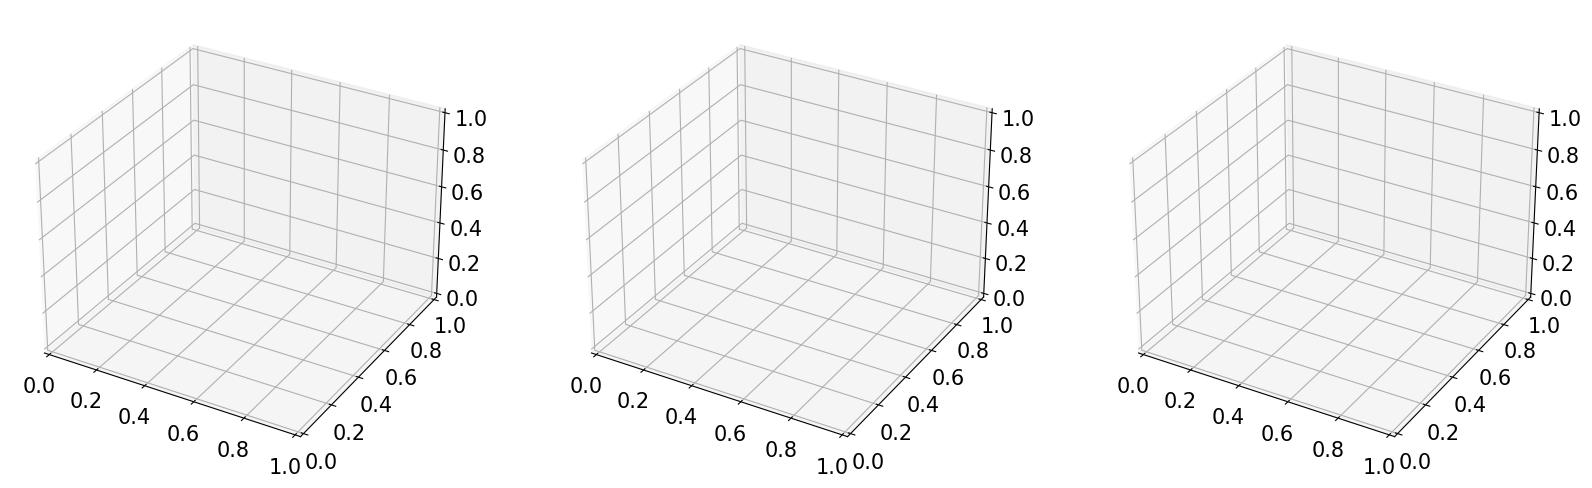

In [44]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [45]:
data = read_data(RES_DIR, folders=["strategies_5runs","strategies_5runs_"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. partisanship: Welch's t-test independent samples, P_val:6.254e-02 t=2.025e+00
random vs. hubs: Welch's t-test independent samples, P_val:2.734e-01 t=1.146e+00
random vs. misinformation: Welch's t-test independent samples, P_val:3.374e-01 t=9.953e-01
random vs. liberal: Welch's t-test independent samples, P_val:9.145e-02 t=1.785e+00
random vs. conservative: Welch's t-test independent samples, P_val:1.203e-01 t=-1.642e+00


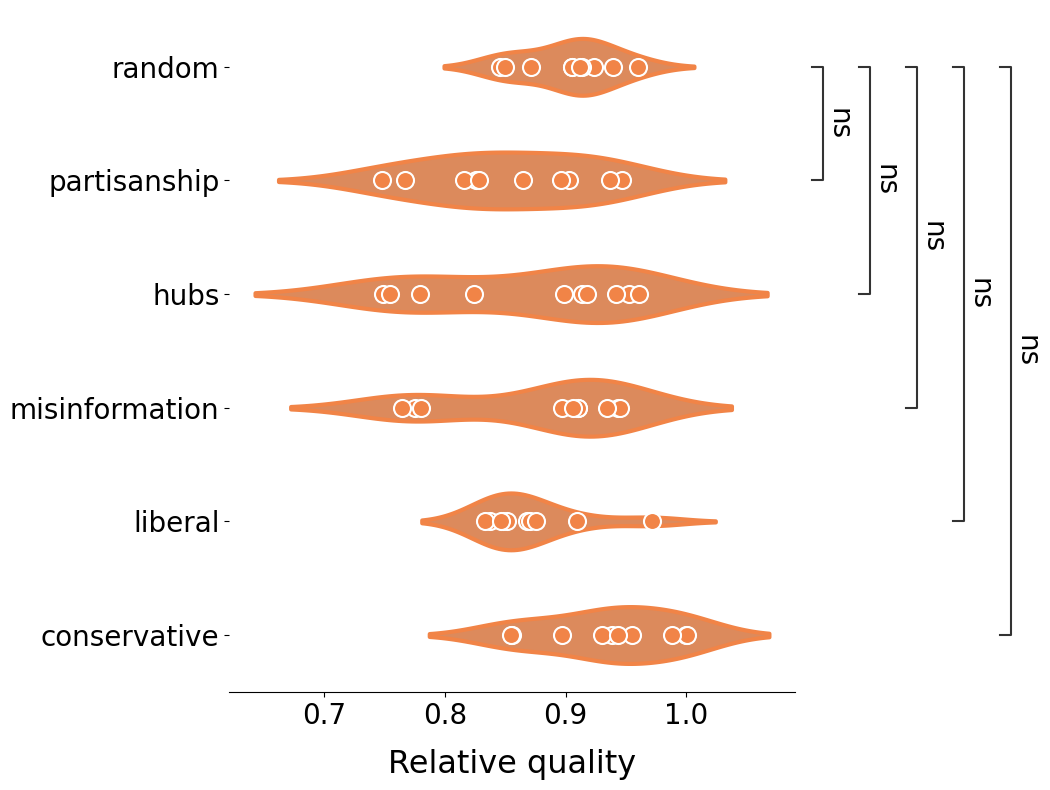

In [46]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()